# Predicting sentiment from product reviews



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read some product review data

Loading reviews for a set of baby products. 

In [2]:
products = pd.read_csv('amazon_baby.csv',dtype={'name':str,'review':str,'rating':np.int64})

# Let's explore this data together

Data includes the product name, the review text and the rating of the review. 

In [3]:
products.head()

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


# Build the word count vector for each review

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
products['review'] = products['review'].fillna('')
vectorizer = CountVectorizer()
analyzer = vectorizer.build_analyzer()

In [6]:
def word_counts(s):
    ans = {}
    if analyzer(s):
        di = {}
        weight = vectorizer.fit_transform([s]).toarray()
        voc = vectorizer.vocabulary_
        for k,v in voc.items():  #k is the word, v is the index
            di[v]=k
        for index,i in enumerate(weight[0]):
            ans[di[index]] = i
    return  ans

In [7]:
products['word_count'] = products['review'].apply(word_counts)

In [8]:
products.head()

,name,review,rating,word_count
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3,"{u'and': 5, u'stink': 1, u'because': 1, u'orde..."
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{u'and': 3, u'love': 1, u'it': 3, u'highly': 1..."
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{u'and': 2, u'would': 1, u'quilt': 1, u'it': 1..."
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{u'and': 3, u'ingenious': 1, u'love': 2, u'wha..."
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{u'and': 2, u'all': 2, u'love': 1, u'help': 1,..."


# Examining the reviews for most-sold product:  'Vulli Sophie the Giraffe Teether'

In [9]:
giraffe_reviews = products[products['name'] == 'Vulli Sophie the Giraffe Teether']

In [10]:
len(giraffe_reviews)

785

In [11]:
giraffe_reviews['rating'].value_counts()

5    535
4     95
3     62
1     56
2     37
Name: rating, dtype: int64

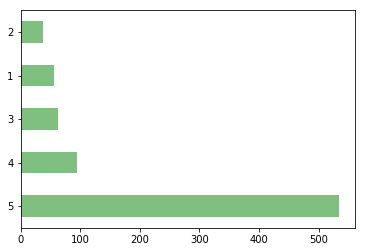

In [12]:
giraffe_reviews['rating'].value_counts().plot(kind='barh',color='g',alpha=0.5)

# Build a sentiment classifier

In [13]:
products['rating'].value_counts()

5    107054
4     33205
3     16779
1     15183
2     11310
Name: rating, dtype: int64

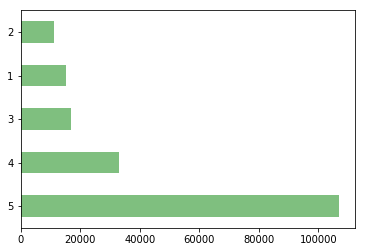

In [14]:
products['rating'].value_counts().plot(kind='barh',color='g',alpha=0.5)

## Define what's a positive and a negative sentiment

We will ignore all reviews with rating = 3, since they tend to have a neutral sentiment.  Reviews with a rating of 4 or higher will be considered positive, while the ones with rating of 2 or lower will have a negative sentiment.   

In [15]:
# ignore all 3* reviews
products = products[products['rating'] != 3]

In [16]:
# positive sentiment = 4* or 5* reviews
products['sentiment'] = products['rating'] >=4

In [17]:
products.head()

,name,review,rating,word_count,sentiment
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5,"{u'and': 3, u'love': 1, u'it': 3, u'highly': 1...",True
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5,"{u'and': 2, u'would': 1, u'quilt': 1, u'it': 1...",True
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5,"{u'and': 3, u'ingenious': 1, u'love': 2, u'wha...",True
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,"{u'and': 2, u'all': 2, u'love': 1, u'help': 1,...",True
5,Stop Pacifier Sucking without tears with Thumb...,"When the Binky Fairy came to our house, we did...",5,"{u'and': 2, u'cute': 1, u'would': 1, u'help': ...",True


## Let's train the sentiment classifier

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [19]:
train_data,test_data = train_test_split(products,train_size=0.8,random_state=0)

In [20]:
sentiment_model = LogisticRegression()
vectorizer.fit(products['review'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [21]:
X = vectorizer.transform(train_data['review'])
y = train_data['sentiment']
sentiment_model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Evaluate the sentiment model

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
def metric_roc_curve(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [24]:
pred = sentiment_model.predict_proba(vectorizer.transform(test_data['review']))[:,1]

In [25]:
fpr,tpr,_ = roc_curve(test_data['sentiment'].values,pred)
roc_auc = auc(fpr,tpr)

In [32]:
#fpr

array([ 0.        ,  0.        ,  0.        , ...,  0.99925401,
        0.99925401,  1.        ])

In [33]:
#tpr

array([  9.28936368e-04,   9.64664690e-04,   1.03612133e-03, ...,
         9.99964272e-01,   1.00000000e+00,   1.00000000e+00])

In [34]:
#len(fpr)

3532

In [36]:
#len(tpr)

3532

In [35]:
#len(test_data['sentiment'])

33351

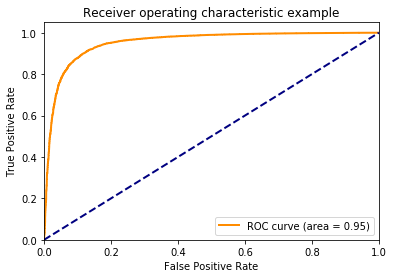

In [37]:
metric_roc_curve(fpr,tpr,roc_auc)

In [38]:
#sentiment_model.evaluate(test_data, metric='roc_curve')

In [39]:
#sentiment_model.show(view='Evaluation')

# Applying the learned model to understand sentiment for Giraffe

In [40]:
giraffe_reviews['predicted_sentiment'] = sentiment_model.predict_proba(vectorizer.transform(giraffe_reviews['review']))[:,1]

In [41]:
giraffe_reviews.head()

,name,review,rating,word_count,predicted_sentiment
34313,Vulli Sophie the Giraffe Teether,He likes chewing on all the parts especially t...,5,"{u'and': 1, u'all': 1, u'because': 1, u'it': 1...",0.998693
34314,Vulli Sophie the Giraffe Teether,My son loves this toy and fits great in the di...,5,"{u'and': 1, u'right': 1, u'help': 1, u'just': ...",0.999293
34315,Vulli Sophie the Giraffe Teether,There really should be a large warning on the ...,1,"{u'and': 2, u'all': 1, u'there': 2, u'being': ...",0.197044
34316,Vulli Sophie the Giraffe Teether,All the moms in my moms\' group got Sophie for...,5,"{u'and': 2, u'all': 1, u'love': 1, u'have': 1,...",0.964265
34317,Vulli Sophie the Giraffe Teether,I was a little skeptical on whether Sophie was...,5,"{u'and': 3, u'the': 3, u'all': 1, u'there': 1,...",0.775302


## Sort the reviews based on the predicted sentiment and explore

In [42]:
giraffe_reviews = giraffe_reviews.sort_values(by = 'predicted_sentiment', ascending=False)

In [43]:
giraffe_reviews.head()

,name,review,rating,word_count,predicted_sentiment
34892,Vulli Sophie the Giraffe Teether,"Sophie, oh Sophie, your time has come. My gran...",5,"{u'giggles': 1, u'all': 1, u'since': 1, u'brin...",1.0
34434,Vulli Sophie the Giraffe Teether,My Mom-in-Law bought Sophie for my son when he...,5,"{u'son': 4, u'think': 1, u'they': 1, u'just': ...",1.0
34515,Vulli Sophie the Giraffe Teether,"As every mom knows, you always want to give yo...",5,"{u'cute': 1, u'all': 1, u'just': 2, u'money': ...",1.0
34975,Vulli Sophie the Giraffe Teether,My 8 week old LOVES Sophie. The rubber feels s...,5,"{u'accurate': 1, u'horns': 1, u'mommies': 1, u...",1.0
34442,Vulli Sophie the Giraffe Teether,"Yes, it\'s imported. Yes, it\'s expensive. And...",5,"{u'help': 1, u'over': 2, u'month': 1, u'four':...",1.0


## Most positive reviews for the giraffe

In [44]:
giraffe_reviews.iloc[0]['review']


"Sophie, oh Sophie, your time has come. My granddaughter, Violet is 5 months old and starting to teeth. What joy little Sophie brings to Violet. Sophie is made of a very pliable rubber that is sturdy but not tough. It is quite easy for Violet to twist Sophie into unheard of positions to get Sophie into her mouth. The little nose and hooves fit perfectly into small mouths, and the drooling has purpose. The paint on Sophie is food quality.Sophie was born in 1961 in France. The maker had wondered why there was nothing available for babies and made Sophie from the finest rubber, phthalate-free on St Sophie\\'s Day, thus the name was born. Since that time millions of Sophie\\'s populate the world. She is soft and for babies little hands easy to grasp. Violet especially loves the bumpy head and horns of Sophie. Sophie has a long neck that easy to grasp and twist. She has lovely, sizable spots that attract Violet\\'s attention. Sophie has happy little squeaks that bring squeals of delight fro

In [45]:
giraffe_reviews.iloc[1]['review']

'My Mom-in-Law bought Sophie for my son when he was just starting to really chew on things (and we were hearing some pretty scary things about toys not made in the USA). She did some research and came across Sophie and we are so glad that she did! While Sophie doesn\\\'t come from the USA, we love the fact that she is 100% safe and natural, and my son loves to play with her. I also love how soft Sophie is, my son tends to swing his toys around and when he\\\'s sitting on my lap I\\\'m usually in danger of being hit in the face with whatever he\\\'s holding, needless to say a soft toy is even better in my book! There\\\'s one last thing I want to comment on, I\\\'ve read reviews that said that Sophie was a "glorified dog toy" or something to that effect, and I don\\\'t want to seem rude, but I think they\\\'re crazy! Yes Sophie does squeak, (which my son didn\\\'t care about much at first but now he loves) but that\\\'s about as far as the comparison could go! If you want a quality teet

## Show most negative reviews for giraffe

In [46]:
giraffe_reviews.iloc[-1]['review']

'I wanted to love this product and was excited to buy it when I became pregnant but am now hesitant to let my baby use it after reading about the recall in Europe. Apparently, as I understand it, their toxin standards of measurement are lower than ours so they have not been recalled here (apparently we are OK with low levels of nitrates in the toys our children put in their mouths, but Europeans are not...hmmm)...Be that as it may, toxins registering even CLOSE to a dangerous level made me nervous about using. After digging around online I did discover that the company claims to have changed the product after a certain date and lists manufacturing codes so you can check yours (those listed were made after a certain date and are said to be safer). Sadly mine was not made after the &#34;improved&#34; date but I could not return it because there was no formal recall in our country. I considered returning it and hunting for one with an approved manufacturing date but man that was just too 

In [47]:
giraffe_reviews.iloc[-2]['review']

"Alright, first off didn\\'t realize this was a squeaky toy.  It is high quality but still same construction as a dog toy.  I really wouldn\\'t of gotten it had I known it squeaked, it drives my dog nuts.  I buy a present for my 4 month old that I now got to make sure the dog doesn\\'t get to.  It\\'s not a bad toy but really nothing special and the fact that it is basically a re-purposed dog toy is rather disappointing, no idea how it goes so many good reviews."

# Question 1

In [48]:
selected_words = ['awesome', 'great', 'fantastic', 'amazing', 'love', 'horrible', 'bad', 'terrible', 'awful', 'wow', 'hate']

In [49]:
def selected_count(dic,word):
    if word in dic:
        return dic[word]
    else:
        return 0

In [50]:
for word in selected_words:
    products[word] = products['word_count'].apply(selected_count,args=(word,))

In [58]:
products['awesome'].head()

1    0
2    0
3    0
4    0
5    0
Name: awesome, dtype: int64

In [59]:
products['word_count'].head()

1    {u'and': 3, u'love': 1, u'it': 3, u'highly': 1...
2    {u'and': 2, u'would': 1, u'quilt': 1, u'it': 1...
3    {u'and': 3, u'ingenious': 1, u'love': 2, u'wha...
4    {u'and': 2, u'all': 2, u'love': 1, u'help': 1,...
5    {u'and': 2, u'cute': 1, u'would': 1, u'help': ...
Name: word_count, dtype: object

In [60]:
word_sum = products[selected_words].sum()

In [61]:
word_sum

awesome       3892
great        55791
fantastic     1664
amazing       2628
love         41994
horrible      1110
bad           4183
terrible      1146
awful          687
wow            425
hate          1107
dtype: int64

In [62]:
print word_sum.argmax(),word_sum.argmin()

great wow


# Question 2

In [63]:
train_data,test_data = train_test_split(products,train_size=0.8,random_state=0)
features = selected_words


In [64]:
selected_words_model = LogisticRegression()

In [65]:
X = train_data[features]
y = train_data['sentiment'].T

In [66]:
selected_words_model.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [76]:
selected_words_model.predict(test_data[features])

array([ True,  True,  True, ...,  True,  True,  True], dtype=bool)

In [77]:
coeff = pd.DataFrame({'name':selected_words,'value':selected_words_model.coef_[0]})

In [78]:
coeff.sort_values(by='value',ascending=False)

,name,value
4,love,1.380930
0,awesome,1.171903
3,amazing,1.054181
2,fantastic,0.900392
1,great,0.865964
9,wow,-0.097348
6,bad,-0.975250
10,hate,-1.433518
8,awful,-2.055797
7,terrible,-2.209991


# Question 3

In [79]:
from sklearn.metrics import accuracy_score

In [80]:
sentiment_model_pred = sentiment_model.predict(vectorizer.transform(test_data['review']))

In [81]:
accuracy_score(test_data['sentiment'],sentiment_model_pred)

0.92923750412281492

In [82]:
selected_words_model_pred = selected_words_model.predict(test_data[features])

In [83]:
accuracy_score(test_data['sentiment'],selected_words_model_pred)

0.8458217144913196

In [84]:
test_data['sentiment'].describe()

count     33351
unique        2
top        True
freq      27989
Name: sentiment, dtype: object

In [85]:
accuracy_score(test_data['sentiment'],np.ones(test_data['sentiment'].shape))

0.83922521063836164

# Question 4

In [86]:
diaper_champ_reviews = products[products.name=='Baby Trend Diaper Champ']

In [87]:
diaper_champ_reviews['predicted_sentiment']= sentiment_model.predict_proba(vectorizer.transform(diaper_champ_reviews['review']))[:,1]

/Users/apple/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [88]:
diaper_champ_reviews.sort_values(by='predicted_sentiment',ascending=False)

,name,review,rating,word_count,sentiment,awesome,great,fantastic,amazing,love,horrible,bad,terrible,awful,wow,hate,predicted_sentiment
376,Baby Trend Diaper Champ,"This is absolutely, by far, the best diaper pa...",5,"{u'lysol': 2, u'just': 3, u'money': 1, u'smell...",True,0,0,0,0,2,0,0,0,0,0,0,1.000000
320,Baby Trend Diaper Champ,I originally put this item on my baby registry...,5,"{u'lysol': 1, u'all': 4, u'feedback': 1, u'jus...",True,0,0,0,0,0,0,0,0,0,0,0,1.000000
414,Baby Trend Diaper Champ,We have been using our Diaper Champ for almost...,5,"{u'son': 3, u'all': 3, u'humid': 1, u'consider...",True,0,0,0,0,0,0,0,0,0,0,0,1.000000
420,Baby Trend Diaper Champ,Baby Luke can turn a clean diaper to a dirty d...,5,"{u'all': 1, u'less': 1, u'nursery': 1, u'absol...",True,0,1,0,0,0,0,0,0,0,0,0,1.000000
571,Baby Trend Diaper Champ,We did alot of research on diaper pails before...,2,"{u'saying': 1, u'just': 1, u'over': 1, u'mainl...",False,0,0,0,0,0,0,0,0,0,0,0,1.000000
451,Baby Trend Diaper Champ,"As a first time mother, I wanted to get the be...",5,"{u'and': 2, u'love': 1, u'questions': 1, u'fig...",True,0,0,0,0,1,0,0,0,0,0,0,1.000000
604,Baby Trend Diaper Champ,I have been using this diaper pail for 41/2 mo...,5,"{u'and': 4, u'all': 1, u'least': 1, u'love': 1...",True,0,2,0,0,1,0,0,0,0,0,0,0.999999
328,Baby Trend Diaper Champ,Diaper Champ or Diaper Genie? That was my dile...,5,"{u'son': 3, u'all': 1, u'before': 1, u'differe...",True,0,1,0,0,0,0,0,0,0,0,0,0.999999
491,Baby Trend Diaper Champ,I can\'t say enough good things about the Cham...,5,"{u'son': 4, u'anyway': 1, u'years': 2, u'messy...",True,0,0,0,0,1,0,0,0,0,0,0,0.999999
477,Baby Trend Diaper Champ,The boy is now 1 year old and we have had it s...,4,"{u'when': 2, u'pleased': 1, u'before': 1, u'pe...",True,0,1,0,0,0,0,1,0,0,0,0,0.999998


In [89]:
diaper_champ_reviews['predicted_sentiment2']= selected_words_model.predict_proba(diaper_champ_reviews[features])[:,1]

/Users/apple/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [90]:
diaper_champ_reviews.sort_values(by='predicted_sentiment2',ascending=False)

,name,review,rating,word_count,sentiment,awesome,great,fantastic,amazing,love,horrible,bad,terrible,awful,wow,hate,predicted_sentiment,predicted_sentiment2
329,Baby Trend Diaper Champ,I LOVE LOVE LOVE this product! It is SO much e...,4,"{u'rating': 1, u'contacted': 1, u'over': 1, u'...",True,0,1,0,0,3,0,0,0,0,0,0,0.999677,0.998251
459,Baby Trend Diaper Champ,"Love it, love it, love it! This lives up to t...",5,"{u'all': 1, u'already': 1, u'love': 3, u'purch...",True,0,0,0,0,3,0,0,0,0,0,0,0.994984,0.995853
446,Baby Trend Diaper Champ,I received my Diaper Champ at my baby shower f...,5,"{u'and': 4, u'love': 3, u'want': 1, u'do': 1, ...",True,0,0,0,0,3,0,0,0,0,0,0,0.992376,0.995853
367,Baby Trend Diaper Champ,"Let me just say, I LOVE THIS PRODUCT!! I used...",5,"{u'all': 1, u'just': 3, u'over': 1, u'yes': 3,...",True,0,1,1,0,1,0,0,0,0,0,0,0.999965,0.988857
604,Baby Trend Diaper Champ,I have been using this diaper pail for 41/2 mo...,5,"{u'and': 4, u'all': 1, u'least': 1, u'love': 1...",True,0,2,0,0,1,0,0,0,0,0,0,0.999999,0.988471
426,Baby Trend Diaper Champ,I love this diaper pale and wouldn\'t dream of...,5,"{u'and': 3, u'love': 1, u'is': 2, u'it': 3, u'...",True,0,2,0,0,1,0,0,0,0,0,0,0.995438,0.988471
394,Baby Trend Diaper Champ,Works great - no smells. LOVE that it uses re...,5,"{u'and': 2, u'love': 1, u'garbage': 1, u'waste...",True,0,2,0,0,1,0,0,0,0,0,0,0.999032,0.988471
456,Baby Trend Diaper Champ,I love this diaper pail. It keeps the diapers ...,4,"{u'and': 1, u'love': 2, u'dont': 1, u'extra': ...",True,0,0,0,0,2,0,0,0,0,0,0,0.999235,0.983703
559,Baby Trend Diaper Champ,I\'ve worked with kids more than half my life....,5,"{u'and': 4, u'genies': 1, u'all': 1, u'because...",True,0,0,0,0,2,0,0,0,0,0,0,0.999994,0.983703
469,Baby Trend Diaper Champ,I have a 10 year old daughter and an 8 month o...,5,"{u'lysol': 1, u'all': 1, u'just': 2, u'over': ...",True,0,0,0,0,2,0,0,0,0,0,0,0.999869,0.983703


In [ ]:
#selected_words_model.predict(diaper_champ_reviews[0:1], output_type='probability')